## 03. PyTorch Computer Vision

### 0. Computer vision library in PyTorch

- `torchvision` - https://pytorch.org/vision/stable/index.html
    - base domain library for PyTorch computer vision
    - contains datasets, model architectures and image transformations often used for computer vision problems
- `torchvision.datasets`
    - get datasets and data loading functions for computer vision
- `torchvision.models`
    - get pretrained computer vision models -> can leverage for own problems
- `torchvision.transforms`
    - functions for mainpulating vision data (images) to be suitable for use with an ML model
- `torch.utils.data.Dataset`
    - base dataset class for PyTorch
- `torch.utils.data.DataLoader`
    - create a Python iterable over dataset

- color channels last: (NHWC) - [batch_size, height, width, color_channels]
- color channels first: (NCHW) - [batch_size, color_channels, height, width]

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
# conert a PIL Image/numpy.ndarray to tensor
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

### 1. Getting a dataset

-> using *'FashionMNIST'* from **torchvision.datasets**

In [2]:
# setup training data
train_data = datasets.FashionMNIST(
    root="data",    # where to download data to
    train=True,     # do we want the training dataset
    download=True,  # do we want to download yes/no?
    transform=torchvision.transforms.ToTensor(),    # how do we want to transform the data
    target_transform=None   # how do we want to transform the labels/target
)

# setup training data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(), 
    target_transform=None
)

#### 1.1 Check the data

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [6]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [7]:
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

#### 1.2 Visualize data

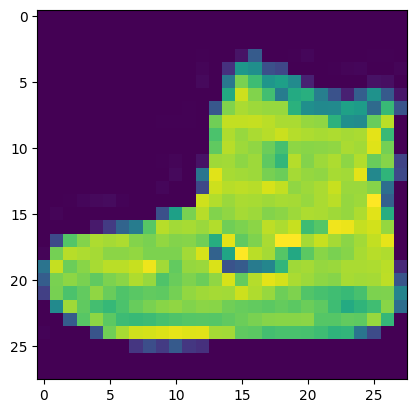

In [8]:
plt.imshow(image.squeeze())
# plt.title(class_names[label])
# plt.axis(False)

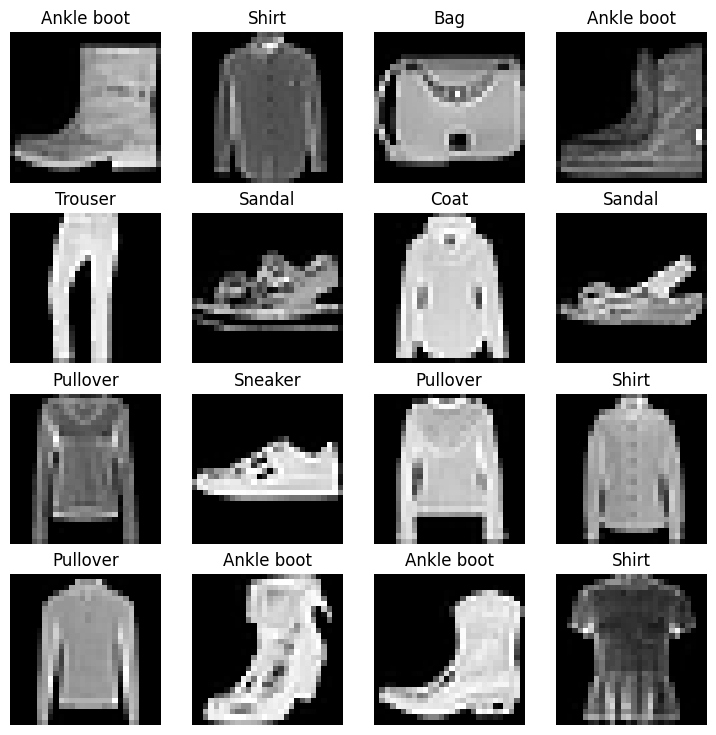

In [9]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

### 2. Prepare dataloader

=> DataLoaders turns dataset into a Python iterable

=> want to turn it into batches (or mini-batches)

=> **Why?**
- (1) more computationally efficient -> computer hardware may not be able to look (store in memory) at 60,000 images in one hit -> break it down to 32 images at a time (batch size of 32)
- (2) gives neural network more chances to update its gradients per epoch



In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x286ab6890>,
 <torch.utils.data.dataloader.DataLoader at 0x286638af0>)

In [11]:
print("Length of train_dataloader:", len(train_dataloader), " -> batches of ", BATCH_SIZE)
print("Length of test_dataloader:", len(test_dataloader), " -> batches of ", BATCH_SIZE)

Length of train_dataloader: 1875  -> batches of  32
Length of test_dataloader: 313  -> batches of  32


In [12]:
# check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

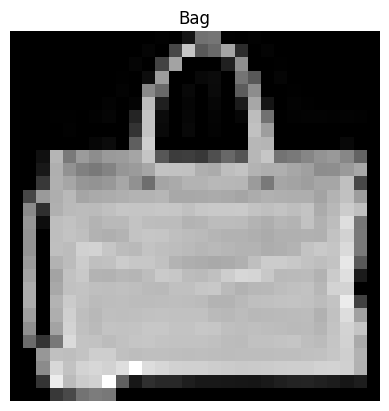

In [13]:
# show a sample
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]

plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

### 3. Model 0: Build a baseline model

=> a simple model -> try and improve upon with subseuent models/experiments
=> start simply and add complexity when necessary

In [14]:
# create a flatten layer
flatten_model = nn.Flatten()

# get a single sample
x = train_features_batch[0]

# flatten the sample
output = flatten_model(x)       # perform forward pass

# color channel, height, width
print("Shape before flattening:", x.shape)
# color channel, height * width
print("Shape after flattening:", output.shape)

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [15]:
from torch import nn

class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_unit: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_unit),
            nn.Linear(in_features=hidden_unit, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [16]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=28*28,
    hidden_unit=10,
    output_shape=len(class_names)
)
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

#### 3.1 setup loss function, optimzer and evaluation metrics

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

from helper_functions import accuracy_fn

#### 3.2 Create a function to time experiment

=> **Main thing to track:**
- Model's performance
- How fast ot runs

In [18]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device=None):
    """ prints difference between start and end time """
    total_time = end - start
    print(f"Train time on {device} : {total_time:.3f} seconds")
    return total_time

In [19]:
start_time = timer()
# some code...
end_time = timer()
print_train_time(start_time, end_time, "cpu")

Train time on cpu : 0.000 seconds


8.917006198316813e-06

#### 3.3 Creating a training loop and training a model on batched of data

- (1) loop through epochs
- (2) loop through training batches, perform training steps, calculate the train loss per batch
- (3) loop through testing batches, perform testing steps, calculate the test loss per batch
- (4) print out what's happening
- (5) time it all

In [20]:
from tqdm.auto import tqdm

In [21]:
torch.manual_seed(42)
train_time_start_cpu = timer()

epochs = 10

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")

    """ training """
    train_loss = 0      # see how this accumulates and average it
    
    # loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()

        y_pred = model_0(X)
        # compute and accumulate train loss
        loss = loss_fn(y_pred, y)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        # update the model parameters once per batch
        optimizer.step()

        if (batch % 400 == 0):
            print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples")

    # divide total train loss by the length of train dataloader
    train_loss /= len(train_dataloader)

    """ testing """
    test_loss, test_acc = 0, 0

    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model_0(X_test)
            test_loss += loss_fn(test_pred, y_test)

            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
        
        # calculate test loss average per batch
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}%")

# calculate training time
train_time_end_cpu = timer()
print_train_time(train_time_start_cpu, train_time_end_cpu, str(next(model_0.parameters()).device))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0 / 60000 samples


Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples

Train loss: 0.5904 | Test loss: 0.5095 | Test acc: 82.0387%
Epoch: 1
-------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples

Train loss: 0.4763 | Test loss: 0.4799 | Test acc: 83.1969%
Epoch: 2
-------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples

Train loss: 0.4550 | Test loss: 0.4766 | Test acc: 83.4265%
Epoch: 3
-------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples

Train loss: 0.4425 | Test loss: 0.4631 | Test acc: 83.7460%
Epoch: 4
-------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples


23.76476754201576

### 4. Make predictions and get model_0 results

In [22]:
torch.manual_seed(42)
def eval_model(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               accuracy_fn):
    """ return a dictionary containing the results of model prediction on data_loader """
    loss, acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # make predictions
            y_pred = model(X)

            # accumulate
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # scale loss and acc to fine the average per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,     # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}


In [23]:
# calculate model 0 results on test dataset
model_0_results = eval_model(model_0, test_dataloader, loss_fn, accuracy_fn)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.462798148393631,
 'model_acc': 83.64616613418531}

### 5. Setup device agnostic code -> MPS

In [24]:
device = "gpu" if torch.cuda.is_available() \
    else "mps" if getattr(torch, 'has_mps', False) else "cpu"
device

/var/folders/df/mx2gggdn7p55_8g8_fxxk8zc0000gn/T/ipykernel_9067/4058462188.py:2: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  else "mps" if getattr(torch, 'has_mps', False) else "cpu"


'mps'

### 6. Model 1: Building a better model with non-linearity


In [25]:
# create a new model with non-linear and linear layer
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_unit: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_unit),
            nn.ReLU(),
            nn.Linear(in_features=hidden_unit, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layer_stack(x)

In [26]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(
    input_shape=28*28,
    hidden_unit=10,
    output_shape=len(class_names)
).to(device)
model_1, next(model_1.parameters()).device

(FashionMNISTModelV1(
   (layer_stack): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=10, bias=True)
     (2): ReLU()
     (3): Linear(in_features=10, out_features=10, bias=True)
     (4): ReLU()
   )
 ),
 device(type='mps', index=0))

In [27]:
# pick a loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

from helper_functions import accuracy_fn

#### 6.1 Functionizing training and evaluate/testing loops

**Create a function for:**
- training loop - `train_step()`
- testing loop - `test_step()`

In [28]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """ performs a training step with model trying to learn on dataloader """
    train_loss, train_acc = 0, 0
    model.to(device)

    # put model into training model
    model.train()
    
    # loop through training batches
    for batch, (X, y) in enumerate(dataloader):
        # put data on target device
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        # compute and accumulate train loss and accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # divide total train loss and accuracy by the length of train dataloader
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")


In [29]:
def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              accuracy_fn,
              device: torch.device = device):    
    """ performs a testing step on model going over dataloader """
    test_loss, test_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X_test, y_test in dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)

            test_pred = model(X_test)
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
        
        # adjust metrics and print out
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")


In [30]:
torch.manual_seed(42)
train_time_start_mps = timer()

epochs = 10

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")

    """ training """
    train_step(model_1, train_dataloader, loss_fn, optimizer, accuracy_fn, device)

    """ testing """
    test_step(model_1, test_dataloader, loss_fn, accuracy_fn, device)

# calculate training time
train_time_end_mps = timer()
print_train_time(train_time_start_mps, train_time_end_mps, str(next(model_1.parameters()).device))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.09199 | Train acc: 61.34%
Test loss: 0.95636 | Test acc: 65.00%

Epoch: 1
-------
Train loss: 0.78097 | Train acc: 71.94%
Test loss: 0.72611 | Test acc: 73.99%

Epoch: 2
-------
Train loss: 0.67040 | Train acc: 75.94%
Test loss: 0.69007 | Test acc: 74.81%

Epoch: 3
-------
Train loss: 0.64420 | Train acc: 76.59%
Test loss: 0.64950 | Test acc: 76.19%

Epoch: 4
-------
Train loss: 0.62845 | Train acc: 76.99%
Test loss: 0.65784 | Test acc: 76.02%

Epoch: 5
-------
Train loss: 0.61573 | Train acc: 77.41%
Test loss: 0.64653 | Test acc: 76.61%

Epoch: 6
-------
Train loss: 0.60636 | Train acc: 77.81%
Test loss: 0.63479 | Test acc: 76.45%

Epoch: 7
-------
Train loss: 0.42583 | Train acc: 85.05%
Test loss: 0.44668 | Test acc: 84.41%

Epoch: 8
-------
Train loss: 0.39843 | Train acc: 85.97%
Test loss: 0.43958 | Test acc: 84.76%

Epoch: 9
-------
Train loss: 0.39301 | Train acc: 86.16%
Test loss: 0.43281 | Test acc: 84.85%

Train time on mps:0 : 66.792 seconds


66.79220274998806

**MPS -> much slower than CPU?**


**Sometimes, depending on data/hardware -> might find that model trains faster on CPU than GPU.**

=> **Why is this?**
- (1) the overhead for copying data/model to and from GPU outweights the compute benefits offer by the GPU
- (2) the hardware using has a better CPU in terms compute capability than the GPU

https://horace.io/brrr_intro.html

In [31]:
torch.manual_seed(42)
def eval_model1(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               accuracy_fn,
               device: torch.device):
    """ return a dictionary containing the results of model prediction on data_loader """
    loss, acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            # make predictions
            y_pred = model(X)

            # accumulate
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # scale loss and acc to fine the average per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,     # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}


In [32]:
# calculate model 0 results on test dataset
model_1_results = eval_model1(model_1, test_dataloader, loss_fn, accuracy_fn, "mps")
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.4328087270259857,
 'model_acc': 84.85423322683707}

### 7. Model 2: Concolutional Neural Networks (CNN)

CNN's -> also knpwn as ConvNets.

-> are known for their capabilities to find patterns in visual data.

-> CNN explainer - https://poloclub.github.io/cnn-explainer/


**Architecture of CNN**

- (1) input images
- (2) imput layer
- (3) convolution layer
- (4) hidden activation/non-linear activation
- (5) pooling layer
- (6) output layer
- (7) output activation

In [33]:
# create a CNN
class CNNModelV0(nn.Module):
    """
    Model architecture that replicates the TinyVGG
    model from CNN explainer website
    """
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # there is a trick to calculating this...
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [34]:
torch.manual_seed(42)
# input_shape -> color channels
model_2 = CNNModelV0(input_shape=1, hidden_units=10, output_shape=len(class_names))

#### 7.1 Stepping through `nn.Conv2d()`

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [35]:
torch.manual_seed(42)

# create a batch of images
images = torch.rand(size=(32, 3, 64, 64))
test_image = images[0]

In [36]:
test_image.shape

torch.Size([3, 64, 64])

In [37]:
# create a single conv2d layer
conv_layer = nn.Conv2d(in_channels = 3,
                       out_channels = 10,
                       kernel_size=(5,5),
                       stride=3,
                       padding=1)

# pass the data through the convolutional layer
# conv_out = conv_layer(test_image.unsqueeze(0))
conv_out = conv_layer(test_image)
conv_out.shape

torch.Size([10, 21, 21])

#### 7.2 Stepping through `nn.MaxPool2d()`

https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

In [38]:
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dim: {test_image.unsqueeze(0).shape}")

# create a single MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# pass data through just the conv_layer
test_image_conv = conv_layer(test_image.unsqueeze(0))
print(f"Shape after going through conv_layer(): {test_image_conv.shape}")

# pass data through the max_pool_layer
test_conv_max_pool = max_pool_layer(test_image_conv)
print(f"Shape after going through max_pool_layer(): {test_conv_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dim: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 21, 21])
Shape after going through max_pool_layer(): torch.Size([1, 10, 10, 10])


In [39]:
rand_image_tensor = torch.randn(size=(1, 28, 28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [40]:
model_2(rand_image_tensor.unsqueeze(0))

tensor([[ 0.0428, -0.0992,  0.0799, -0.0472,  0.0057,  0.0330,  0.0112, -0.0031,
         -0.0084, -0.0122]], grad_fn=<AddmmBackward0>)

### 7.3 Set up loss function and optimizer

In [41]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

#### 7.4 Training and testing loop

In [42]:
from timeit import default_timer as timer

torch.manual_seed(42)
train_time_start_model_2 = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")

    """ training """
    train_step(model_2, train_dataloader, loss_fn, optimizer, accuracy_fn, "cpu")

    """ testing """
    test_step(model_2, test_dataloader, loss_fn, accuracy_fn, "cpu")

# calculate training time
train_time_end_model_2 = timer()
total_train_time_model2 = print_train_time(train_time_start_model_2,
                                           train_time_end_model_2,
                                           str(next(model_2.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.59355 | Train acc: 78.48%
Test loss: 0.40828 | Test acc: 85.40%

Epoch: 1
-------
Train loss: 0.36563 | Train acc: 86.82%
Test loss: 0.36302 | Test acc: 86.39%

Epoch: 2
-------
Train loss: 0.32580 | Train acc: 88.16%
Test loss: 0.33149 | Test acc: 87.95%

Train time on cpu : 102.606 seconds


In [43]:
# compare with MPS
torch.manual_seed(42)
# input_shape -> color channels
model_2_mps = CNNModelV0(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
model_2_mps

CNNModelV0(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [44]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2_mps.parameters(), lr=0.1)

In [45]:
from timeit import default_timer as timer

torch.manual_seed(42)
train_time_start_model_2_mps = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")

    """ training """
    train_step(model_2_mps, train_dataloader, loss_fn, optimizer, accuracy_fn, device)

    """ testing """
    test_step(model_2_mps, test_dataloader, loss_fn, accuracy_fn, device)

# calculate training time
train_time_end_model_2_mps = timer()
total_train_time_model2_mps = print_train_time(train_time_start_model_2_mps,
                                               train_time_end_model_2_mps,
                                               str(next(model_2_mps.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.59511 | Train acc: 78.44%
Test loss: 0.39709 | Test acc: 85.90%

Epoch: 1
-------
Train loss: 0.36166 | Train acc: 87.03%
Test loss: 0.34959 | Test acc: 86.88%

Epoch: 2
-------
Train loss: 0.32407 | Train acc: 88.37%
Test loss: 0.31861 | Test acc: 88.24%

Train time on mps:0 : 27.014 seconds


In [46]:
model_2_results = eval_model1(model_2_mps, test_dataloader, loss_fn, accuracy_fn, "mps")
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'CNNModelV0',
 'model_loss': 0.3186118006706238,
 'model_acc': 88.2388178913738}

### 8. Make predictions on randm samples on test dataset

In [57]:
def make_predictions(model: nn.Module,
                     data:list,
                     device: torch.device = device):
    pred_probs = []

    model.to(device)
    model.eval()
    with torch. inference_mode():
        for sample in data:
            # prepare -> add a batch dimension & pass to  target device
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # forward pass
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            
            # get pred_prob off the GPU for further calculation
            pred_probs.append(pred_prob.cpu())

    # stacks the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [65]:
import random
# random.seed(42)
test_samples = []
test_labels = []

# get 9 random samples and labels
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# view the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

In [66]:
# make predictions
pred_probs = make_predictions(model_2_mps, test_samples, device)

# view the first 2 prediction probabilities
pred_probs[:2]

tensor([[7.0605e-06, 1.6722e-07, 1.4441e-07, 9.4733e-06, 8.5774e-08, 1.2497e-01,
         6.5042e-07, 9.5706e-02, 7.8730e-04, 7.7851e-01],
        [8.2261e-07, 9.2745e-08, 1.8431e-07, 3.5077e-07, 6.1449e-07, 2.1350e-04,
         1.4292e-07, 9.8152e-01, 2.1830e-05, 1.8244e-02]])

In [67]:
# turn probabilities into labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([9, 7, 2, 0, 1, 0, 3, 5, 4])

In [68]:
test_labels

[9, 7, 2, 0, 1, 0, 4, 5, 4]

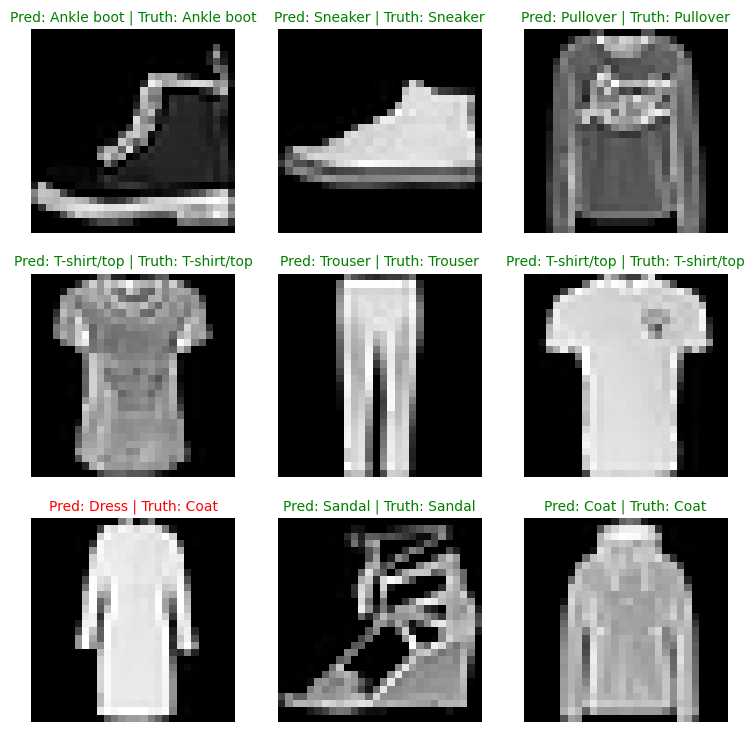

In [69]:
# plot predictions
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
    # create subplot
    plt.subplot(nrows, ncols, i+1)

    # plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # find the prediction
    pred_labels = class_names[pred_classes[i]]

    # get the truth label
    truth_label = class_names[test_labels[i]]

    title_test = f"Pred: {pred_labels} | Truth: {truth_label}"

    # check for equality between and change color of the title text
    if pred_labels == truth_label:
        plt.title(title_test, fontsize=10, c="g")
    else:
        plt.title(title_test, fontsize=10, c="r")

    plt.axis(False)

### 9. Make a confusion matrix

- (1) Make predictions on the test data
- (2) Make a confusion matrix using `torchmatrix.ConfusionMatrix`
- (3) Plot the confusion matrix `mlxtend.plotting.plot_confusion_matrix()`

In [72]:
import mlxtend
mlxtend.__version__

'0.22.0'

In [74]:
# make predictions
y_preds = []

model_2_mps.eval()
with torch.inference_mode():
    for X_test, y_test in tqdm(test_dataloader, desc="Making predictions..."):
        X_test, y_test = X_test.to(device), y_test.to(device)

        y_logits = model_2_mps(X_test)
        y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)
        
        y_preds.append(y_pred.cpu())

# calculate list of predictions into a tensor
# print(y_preds)
y_preds_tensor = torch.cat(y_preds)
y_preds_tensor[:10]

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

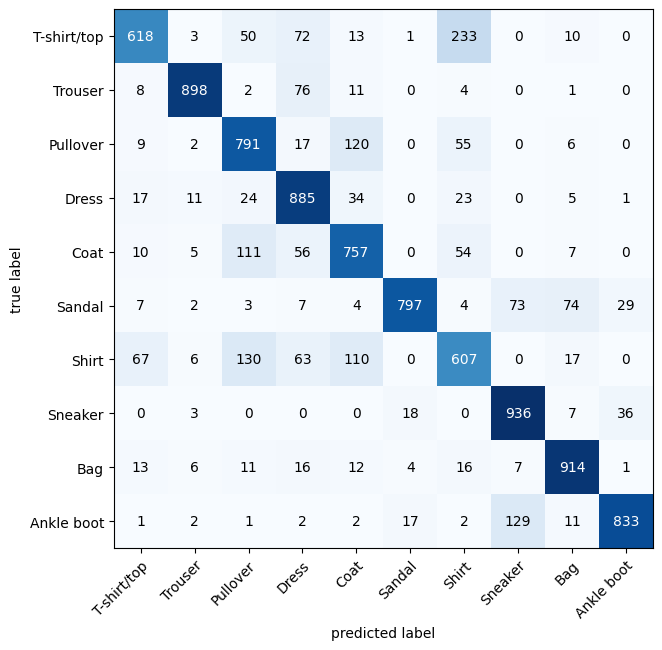

In [76]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds_tensor,
                         target=test_data.targets)

# 3. create confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

### 10. Save and load best performing model

In [77]:
# save model
from pathlib import Path

# create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. create model save path
MODEL_NAME = "03_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(MODEL_SAVE_PATH)

# save the model_1
torch.save(obj=model_2_mps.state_dict(), f=MODEL_SAVE_PATH)

models/03_computer_vision_model_2.pth


In [78]:
# load model
load_model_2 = CNNModelV0(input_shape=1, hidden_units=10, output_shape=len(class_names))

# load the state dict
load_model_2.load_state_dict(torch.load(MODEL_SAVE_PATH))
load_model_2.to(device)

CNNModelV0(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [79]:
# evaluate loaded model
torch.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()

load_model_2_results = eval_model1(load_model_2, test_dataloader, loss_fn, accuracy_fn, "mps")
load_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'CNNModelV0',
 'model_loss': 0.30537569522857666,
 'model_acc': 88.7879392971246}

In [80]:
model_2_results

{'model_name': 'CNNModelV0',
 'model_loss': 0.30537569522857666,
 'model_acc': 88.7879392971246}

In [82]:
torch.isclose(torch.tensor(model_2_results["model_loss"]),
               torch.tensor(load_model_2_results["model_loss"]),
               atol=1e-08)

tensor(True)